In [1]:
include("ion13-params.jl");

In [2]:
using LinearAlgebra

In [3]:
using MSSim: FarDetune as FD, Optimizers as Opts
using NLopt
using StaticArrays
using PyPlot

In [4]:
const NSeg = 15
const NIons = 13
const NArgs = 2 * NSeg + NIons * (NSeg + 1)

238

In [5]:
const tgt = FD.AreaTargets{NIons}()
const tgt_scale = 1.5
for i in 1:NIons - 1
    tgt[i, i + 1] = tgt_scale * ((i % 2) == 1 ? 0.01 : 0.02)
end
for i in 1:NIons - 1
    for j in i + 1:NIons
        Δ = j - i
        if i == 1 || j == NIons
            w = 0.0
        elseif Δ > 3
            w = 0.002
        elseif Δ > 2
            w = 0.5
        else
            w = 1.0
        end
        FD.setweight!(tgt, w, i, j)
    end
end

In [6]:
const kern = FD.Kernel{NSeg}(2π .* fs, bij, ηs);

In [7]:
const tracker = Opts.NLVarTracker(NArgs)
for i in 1:NSeg
    Opts.set_bound!(tracker, i, 1, 5)
end
for i in NSeg + 1:NSeg + NIons * (NSeg + 1)
    Opts.set_bound!(tracker, i, -1, 1)
end
for i in NSeg + NIons * (NSeg + 1) + 1:2 * NSeg + NIons * (NSeg + 1)
    Opts.set_bound!(tracker, i, 2π * 2, 2π * 2.12)
end

In [8]:
const opt = NLopt.Opt(:LD_LBFGS, NArgs)
NLopt.maxtime!(opt, 10)
NLopt.lower_bounds!(opt, Opts.lower_bounds(tracker))
NLopt.upper_bounds!(opt, Opts.upper_bounds(tracker))

In [9]:
const total_time_weight = FD.TotalTimeWeight{NSeg}() do t, grad
    if !isempty(grad)
        grad[1] = 1.0
    end
    return t
end

MSSim.FarDetune.TotalTimeWeight{15, var"#5#6"}(var"#5#6"())

In [10]:
function objective(x, grad)
    return total_time_weight(x, grad) do x, grad
        return kern(tgt, x, grad)
    end
end
NLopt.min_objective!(opt, objective)

In [11]:
function opt_one!(opt, tracker, args_buff)
    objval, args, ret = NLopt.optimize!(opt, Opts.init_vars!(tracker, args_buff))
    if getfield(NLopt, ret)::NLopt.Result < 0
        return
    end
    return objval, args
end

opt_one! (generic function with 1 method)

In [12]:
function opt_rep(opt, tracker, n)
    args_buff = Vector{Float64}(undef, ndims(opt))
    best_val = 1
    best_args = nothing
    for i in 1:n
        res = @time opt_one!(opt, tracker, args_buff)
        if res === nothing
            continue
        end
        val, args = res
        if val < best_val
            @show val
            best_val = val
            best_args = copy(args)
        end
    end
    return best_val, best_args
end

opt_rep (generic function with 1 method)

In [13]:
best_val, best_args = @time opt_rep(opt, tracker, 20)

  0.472468 seconds (234.53 k allocations: 9.749 MiB, 43.19% compilation time)
val = 1.1987116953029784e-8
  0.180483 seconds (3 allocations: 80 bytes)
  0.110002 seconds
  0.160639 seconds
val = 6.091612477244754e-9
  0.205376 seconds
val = 5.173563491079984e-9
  0.214111 seconds
  0.171705 seconds
  0.320416 seconds
  0.143882 seconds
  0.084859 seconds
val = 4.6314449617510905e-9
  0.132858 seconds
val = 4.089395064853487e-9
  0.127156 seconds
val = 1.9413330894521875e-9
  0.084406 seconds
  0.172725 seconds
  0.180930 seconds
  0.134619 seconds
  0.141166 seconds
  0.121168 seconds
  0.165157 seconds
  0.091213 seconds
  3.475173 seconds (362.35 k allocations: 16.199 MiB, 7.55% compilation time)


(1.9413330894521875e-9, [5.0, 5.0, 5.0, 5.0, 2.3415240103580865, 3.966333104627123, 2.675204356356588, 4.33806407538414, 3.0501289395526214, 3.717926151674439  …  13.309799190683746, 13.320352851220724, 13.320352851220724, 13.320352851220724, 13.320352851220724, 13.320352851220724, 13.320352851220724, 13.320352851220724, 13.21089554206137, 13.134301240190672])

In [14]:
best_couplings = Matrix(FD.AreaTargets(kern, best_args))

13×13 Matrix{Float64}:
  0.0         -0.0040753    7.73448e-6  …  -1.03843e-5  -1.33261e-5
 -0.0040753    0.0          0.03            2.18483e-6   1.0438e-6
  7.73448e-6   0.03         0.0            -1.51525e-5  -4.70283e-7
 -5.98526e-5  -1.87441e-7   0.015          -1.3299e-5   -7.48696e-6
 -4.03289e-5  -1.06396e-6  -1.26433e-7     -1.77588e-5  -1.61154e-5
 -1.51544e-5   6.43398e-6  -9.44538e-9  …   6.50453e-6  -1.84883e-5
  2.90215e-6  -4.59411e-6  -2.93045e-6      2.9043e-5    7.50761e-6
  2.76282e-5  -1.3495e-5   -4.28657e-5      2.48161e-5   5.30857e-5
  1.74383e-5  -1.26664e-5  -5.95827e-6      1.07673e-8   2.1022e-5
  9.65801e-6  -2.98405e-5  -5.26437e-5      2.13085e-8  -3.73872e-5
  2.13325e-6  -3.15507e-5  -2.39883e-5  …   0.015        1.26702e-5
 -1.03843e-5   2.18483e-6  -1.51525e-5      0.0          0.0020277
 -1.33261e-5   1.0438e-6   -4.70283e-7      0.0020277    0.0

In [15]:
function plot0(data)
    m = maximum(abs.(data))
    imshow(data, vmax=m, vmin=-m, cmap="bwr")
end

plot0 (generic function with 1 method)

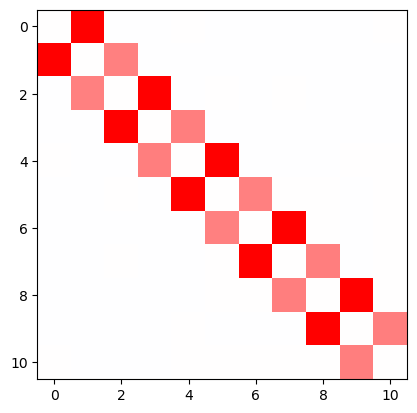

In [16]:
plot0(best_couplings[2:NIons - 1, 2:NIons - 1])
savefig("imgs/qsim_coupling_20251030.png")

In [17]:
print(best_args)

[5.0, 5.0, 5.0, 5.0, 2.3415240103580865, 3.966333104627123, 2.675204356356588, 4.33806407538414, 3.0501289395526214, 3.717926151674439, 3.193861294437151, 1.9519565103954497, 4.62443109573128, 5.0, 5.0, -0.9420492998758827, -0.7649013063139141, 0.15909305655044537, -0.6437714467519777, 0.1891047545339135, 0.9326759947071372, 0.29010873141521554, 0.23747130373357006, 0.6185459046222417, -0.7524005109252347, -0.8854971477282374, 0.8657524845898252, -0.18320557572422214, -0.45321703247331246, -0.5358510581137101, -0.7437488316888823, 1.0, 1.0, 1.0, 0.3231035218918812, 1.0, 1.0, 1.0, -1.0, -1.0, 0.1109096116447115, -0.8215696961218366, -0.9439117208437765, -0.4251484272101438, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 0.7479282957786737, 1.0, 1.0, -0.9890051205560857, -1.0, 1.0, -1.0, -1.0, -1.0, 0.9982732450180691, 1.0, 1.0, 1.0, 1.0, -0.3587878574060264, -1.0, -1.0, -0.002024922964911186, 1.0, 1.0, 0.992124678628626, 1.0, -0.4539454736260516, 0.6198327183905461, -1.0, 0.47616983565061033, 1.0,

In [18]:
fs

13-element Vector{Float64}:
 2.25874
 2.27776
 2.29897
 2.32146
 2.34426
 2.36689
 2.38909
 2.41038
 2.43035
 2.44859
 2.4637
 2.479
 2.48706

In [19]:
function couple(ion1, ion2, δ)
    if ion1 == ion2
        return 0.0
    end
    return FD.enclosed_area_modes(1.0, 1.0, 1.0, 1.0, 1.0, δ, 2π .* fs, kern.weights[:, FD.pair_idx(NIons, ion1, ion2)], ())
end

couple (generic function with 1 method)

In [20]:
couple_matrix = [couple(i, j, 2π * 2.2) for i in 1:NIons, j in 1:NIons]

13×13 Matrix{Float64}:
  0.0           0.000798134  -8.01036e-5   …  -1.91114e-6   -4.114e-6
  0.000798134   0.0           0.00178392      -3.95477e-7   -1.91114e-6
 -8.01036e-5    0.00178392    0.0              1.80857e-6    1.89242e-7
  5.13541e-5   -0.000387378   0.00289233       3.48865e-8    2.54282e-6
  1.19699e-6    0.000163501  -0.000821506      8.80978e-6    3.63598e-6
  1.37227e-5   -4.02986e-5    0.000330061  …  -2.27431e-6    6.5603e-6
  6.07893e-6    2.83892e-5   -0.000106058      2.83892e-5    6.07893e-6
  6.5603e-6    -2.27431e-6    5.45915e-5      -4.02986e-5    1.37227e-5
  3.63598e-6    8.80978e-6   -1.67374e-5       0.000163501   1.19699e-6
  2.54282e-6    3.48865e-8    1.32826e-5      -0.000387378   5.13541e-5
  1.89242e-7    1.80857e-6   -1.73381e-6   …   0.00178392   -8.01036e-5
 -1.91114e-6   -3.95477e-7    1.80857e-6       0.0           0.000798134
 -4.114e-6     -1.91114e-6    1.89242e-7       0.000798134   0.0

In [21]:
diag(couple_matrix, 1)[2:end - 1]

10-element Vector{Float64}:
 0.0017839177434991551
 0.0028923284731479436
 0.0038304334992680105
 0.004409200814817597
 0.004656091989376051
 0.004656091989370819
 0.004409200814823805
 0.003830433499264235
 0.002892328473148626
 0.0017839177434989526

In [22]:
diag(couple_matrix, 2)[2:end - 1]

9-element Vector{Float64}:
 -0.00038737781139736596
 -0.0008215057435055973
 -0.0012086068380869842
 -0.0014451451717169517
 -0.001521025286034131
 -0.0014451451717270648
 -0.0012086068380870343
 -0.0008215057435050606
 -0.0003873778113973432

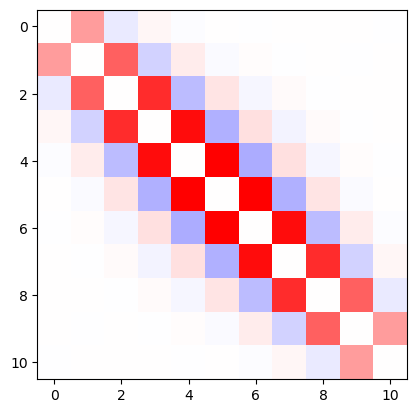

PyObject <matplotlib.image.AxesImage object at 0xfffecf8d2490>

In [23]:
plot0(couple_matrix[2:end - 1, 2:end - 1])

In [24]:
sum(Matrix(tgt)) / 2

0.27

In [25]:
couple_matrix[3, 5], couple_matrix[3, 4]

(-0.0008215057435055973, 0.0028923284731479436)